In [ ]:
def batchnorm_forward(x, gamma, beta, bn_param):
    """Forward pass for batch normalization.

    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the
    mean and variance of each feature, and these averages are used to normalize
    data at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7
    implementation of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param["mode"]
    eps = bn_param.get("eps", 1e-5)
    momentum = bn_param.get("momentum", 0.9)

    N, D = x.shape
    running_mean = bn_param.get("running_mean", np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get("running_var", np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == "train":
        #######################################################################
        # TODO: Implement the training-time forward pass for batch norm.      #
        # Use minibatch statistics to compute the mean and variance, use      #
        # these statistics to normalize the incoming data, and scale and      #
        # shift the normalized data using gamma and beta.                     #
        #                                                                     #
        # You should store the output in the variable out. Any intermediates  #
        # that you need for the backward pass should be stored in the cache   #
        # variable.                                                           #
        #                                                                     #
        # You should also use your computed sample mean and variance together #
        # with the momentum variable to update the running mean and running   #
        # variance, storing your result in the running_mean and running_var   #
        # variables.                                                          #
        #                                                                     #
        # Note that though you should be keeping track of the running         #
        # variance, you should normalize the data based on the standard       #
        # deviation (square root of variance) instead!                        #
        # Referencing the original paper (https://arxiv.org/abs/1502.03167)   #
        # might prove to be helpful.                                          #
        #######################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        mu = np.mean(x, axis=0)

        xmu = x - mu
        sq = xmu ** 2
        var = np.var(x, axis=0)

        sqrtvar = np.sqrt(var + eps)
        ivar = 1./sqrtvar
        xhat = xmu * ivar

        out = gamma * xhat + beta

        cache = (xhat, gamma, xmu, ivar, sqrtvar, var, eps)

        running_mean = momentum * running_mean + (1 - momentum) * mu
        running_var = momentum * running_var + (1 - momentum) * var

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #######################################################################
        #                           END OF YOUR CODE                          #
        #######################################################################
    elif mode == "test":
        #######################################################################
        # TODO: Implement the test-time forward pass for batch normalization. #
        # Use the running mean and variance to normalize the incoming data,   #
        # then scale and shift the normalized data using gamma and beta.      #
        # Store the result in the out variable.                               #
        #######################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        x_normalize = (x - running_mean) / np.sqrt(running_var + eps)
        out = gamma * x_normalize + beta

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        #######################################################################
        #                          END OF YOUR CODE                           #
        #######################################################################
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param["running_mean"] = running_mean
    bn_param["running_var"] = running_var

    return out, cache

**batchnorm_forward**  


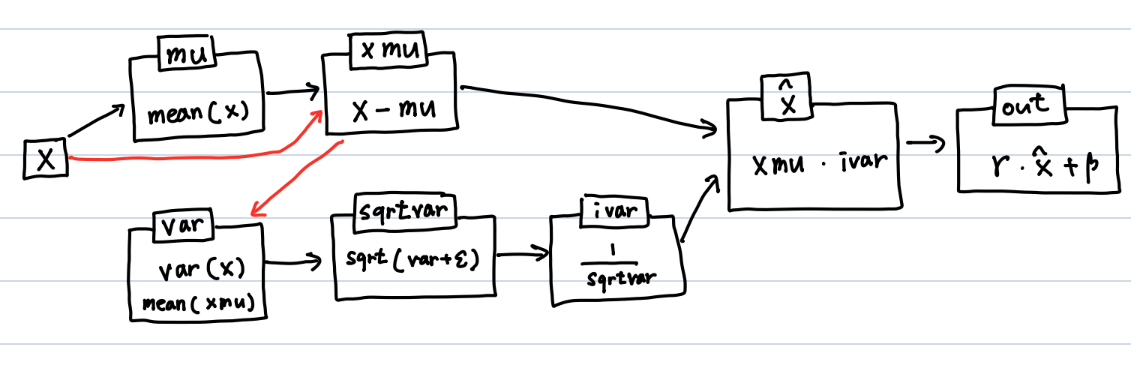

In [ ]:
def batchnorm_backward(dout, cache):
    """Backward pass for batch normalization.

    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    ###########################################################################
    # TODO: Implement the backward pass for batch normalization. Store the    #
    # results in the dx, dgamma, and dbeta variables.                         #
    # Referencing the original paper (https://arxiv.org/abs/1502.03167)       #
    # might prove to be helpful.                                              #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    N, D = dout.shape

    xhat, gamma, xmu, ivar, sqrtvar, var, eps = cache

    dbeta = np.sum(dout, axis=0)
    dgamma = np.sum(dout*xhat, axis=0)
    dxhat = dout * gamma

    divar = np.sum(dxhat*xmu, axis=0)
    dxmu1 = dxhat * ivar

    dsqrtvar = -1. / (sqrtvar**2) * divar
    dvar = 0.5 * 1. / np.sqrt(var+eps) * dsqrtvar

    dsq = 1. / N * np.ones((N, D)) * dvar
    dxmu2 = 2 * xmu * dsq

    dx1 = dxmu1 + dxmu2

    dmu = -1 * np.sum(dx1, axis=0)

    dx2 = 1. / N * np.ones((N, D)) * dmu

    dx = dx1 + dx2 

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta

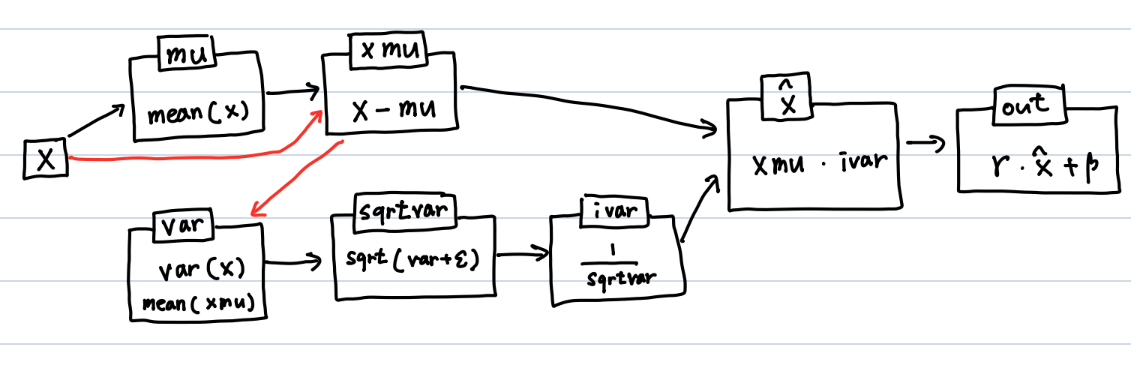

**batchnorm_backward**  

>$ dβ = \frac{dLoss}{dout} \cdot \frac{dout}{dβ} = dout$  
$ dγ = \frac{dLoss}{dout} \cdot \frac{dout}{dγ} = dout \cdot x̂ $  
$ dx̂ = \frac{dLoss}{dout} \cdot \frac{dout}{dx̂} = dout \cdot γ $  
>
>>$ dxmu_{1} = \frac{dLoss}{dx̂} \cdot \frac{dx̂}{dxmu} = dx̂ \cdot ivar $  
>>
>>$ divar = \frac{dLoss}{dx̂} \cdot \frac{dx̂}{divar} = dx̂ \cdot xmu $  
>>  
$ dsqrtvar = \frac{dLoss}{divar} \cdot \frac{divar}{dsqrtvar} = divar \cdot \frac{-1}{sqrtvar^{2}} $  
$ dvar = \frac{dLoss}{dsqrtvar} \cdot \frac{dsqrtvar}{dvar} = dsqrvar \cdot \frac{-1}{2 \sqrt{var+eps}} $ 
>>
>>$ dxmu_{2} = \frac{dLoss}{dvar} \cdot \frac{dvar}{dxmu} = dvar \cdot \frac{2}{N}\sum{xmu} $ 
>
> $ dxmu = dxmu_{1} + dxmu_{2} $  
>
>>$ dx_{1} = \frac{dLoss}{dxmu} \cdot \frac{dxmu}{dx} = dxmu$  
>>$ dmu = \frac{dLoss}{dxmu} \cdot \frac{dxmu}{dmu} = -dxmu $  
>>
>>$ dx_{2} = \frac{dLoss}{dmu} \cdot \frac{dmu}{dx} = dmu \cdot \frac{1}{N}\sum{1} $  
>  
>$ dx = dx_{1} + dx_{2}$


In [ ]:
 def batchnorm_backward_alt(dout, cache):
    """Alternative backward pass for batch normalization.

    For this implementation you should work out the derivatives for the batch
    normalizaton backward pass on paper and simplify as much as possible. You
    should be able to derive a simple expression for the backward pass.
    See the jupyter notebook for more hints.

    Note: This implementation should expect to receive the same cache variable
    as batchnorm_backward, but might not use all of the values in the cache.

    Inputs / outputs: Same as batchnorm_backward
    """
    dx, dgamma, dbeta = None, None, None
    ###########################################################################
    # TODO: Implement the backward pass for batch normalization. Store the    #
    # results in the dx, dgamma, and dbeta variables.                         #
    #                                                                         #
    # After computing the gradient with respect to the centered inputs, you   #
    # should be able to compute gradients with respect to the inputs in a     #
    # single statement; our implementation fits on a single 80-character line.#
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    N, D = dout.shape
    
    xhat, gamma, xmu, ivar, sqrtvar, var, eps = cache

    dxhat = dout * gamma
    
    # Ref: https://kevinzakka.github.io/2016/09/14/batch_normalization/
    dx = 1.0/N * ivar * (N*dxhat - np.sum(dxhat, axis=0) - xhat*np.sum(dxhat*xhat, axis=0))
    dbeta = np.sum(dout, axis=0)
    dgamma = np.sum(xhat*dout, axis=0)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return dx, dgamma, dbeta

In [ ]:
def layernorm_forward(x, gamma, beta, ln_param):
    """Forward pass for layer normalization.

    During both training and test-time, the incoming data is normalized per data-point,
    before being scaled by gamma and beta parameters identical to that of batch normalization.

    Note that in contrast to batch normalization, the behavior during train and test-time for
    layer normalization are identical, and we do not need to keep track of running averages
    of any sort.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - ln_param: Dictionary with the following keys:
        - eps: Constant for numeric stability

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    out, cache = None, None
    eps = ln_param.get("eps", 1e-5)
    ###########################################################################
    # TODO: Implement the training-time forward pass for layer norm.          #
    # Normalize the incoming data, and scale and  shift the normalized data   #
    #  using gamma and beta.                                                  #
    # HINT: this can be done by slightly modifying your training-time         #
    # implementation of  batch normalization, and inserting a line or two of  #
    # well-placed code. In particular, can you think of any matrix            #
    # transformations you could perform, that would enable you to copy over   #
    # the batch norm code and leave it almost unchanged?                      #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    x = x.T

	# Just copy from batch normalization cdoe
    mu = np.mean(x, axis=0)

    xmu = x - mu
    sq = xmu ** 2
    var = np.var(x, axis=0)

    sqrtvar = np.sqrt(var + eps)
    ivar = 1./sqrtvar
    xhat = xmu * ivar

    # Transpose back, now shape of xhat (N, D)
    xhat = xhat.T
    
    # Just copy from batch normalization cdoe
    out = gamma * xhat + beta

    cache = (xhat, gamma, xmu, ivar, sqrtvar, var, eps)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return out, cache

배치   정규화 : (a - 채널별 평균(a)) / root(채널별 분산(a)+epsilon) * gamma + beta

레이어 정규화 : (a - 데이터별 평균(a)) / root(데이터별 분산(a)+epsilon) * gamma + beta 

In [ ]:
def layernorm_backward(dout, cache):
    """Backward pass for layer normalization.

    For this implementation, you can heavily rely on the work you've done already
    for batch normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from layernorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    ###########################################################################
    # TODO: Implement the backward pass for layer norm.                       #
    #                                                                         #
    # HINT: this can be done by slightly modifying your training-time         #
    # implementation of batch normalization. The hints to the forward pass    #
    # still apply!                                                            #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    xhat, gamma, xmu, ivar, sqrtvar, var, eps = cache

    dbeta = np.sum(dout, axis=0)
    dgamma = np.sum(xhat*dout, axis=0)

    dxhat = dout * gamma

    # Transpose dxhat and xhat back
    dxhat = dxhat.T
    xhat = xhat.T

    # Actually xhat's shape is (D, N), we use notation (N, D) to let us copy
    # batch normalization backward code when computing dx without change anything
    N, D = xhat.shape

    # Copy from batch normalization backward code
    dx = 1.0/N * ivar * (N*dxhat - np.sum(dxhat, axis=0) - xhat*np.sum(dxhat*xhat, axis=0))

    # Transpose dx back
    dx = dx.T

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return dx, dgamma, dbeta